/tmp/ipython-input-1446360030.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period = '90d', interval ='1h')
[*********************100%***********************]  3 of 3 completed


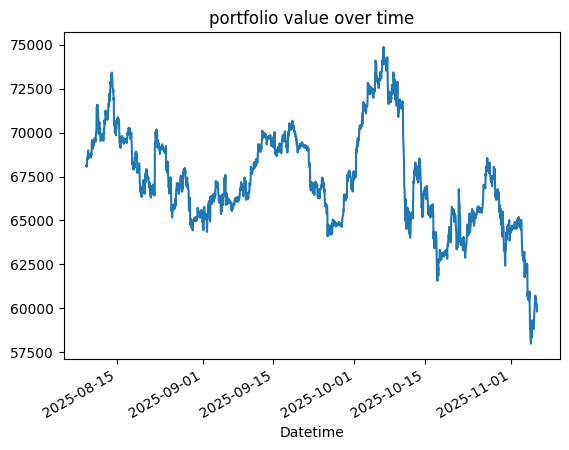

In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Define portfolio weights/positions
portfolio = {
    'BTC-USD': 0.5, # 0.5 units of BTC
    'ETH-USD': 2.0,  # 2 units of ETH
    'SOL-USD': 10.0 # 10 units of SOL
}

# Download recent price data
tickers = list(portfolio.keys())
data = yf.download(tickers, period = '90d', interval ='1h')
data.tail()

# Portfolio Value calculation
positions = pd.DataFrame({t: portfolio[t] * data['Close', t] for t in portfolio})
portfolio_value = positions.sum(axis=1)
portfolio_value.plot(title='portfolio value over time')
portfolio_value.tail()
plt.show()


In [39]:
# Calculate returns and PnL
returns = portfolio_value.pct_change().fillna(0)
pnl = portfolio_value - portfolio_value.iloc[0]

print('Final Portfolio Value:', portfolio_value.iloc[-1])
print('Total PnL:', pnl.iloc[-1])


Final Portfolio Value: 59827.74890136719
Total PnL: -8267.556182861328


In [40]:
# Calculate exposure contribution (%) of each asset

last_prices = data.iloc[-1]
exposure = {t: portfolio[t] * last_prices['Close', t] for t in portfolio}
total_notional_amount = sum(exposure.values())
exposure_pct = {t: exposure[t] / total_notional_amount for t in exposure}
pd.DataFrame.from_dict(exposure_pct, orient='index', columns=['Exposure %'])

,Exposure %
BTC-USD,0.859694
ETH-USD,0.113434
SOL-USD,0.026872


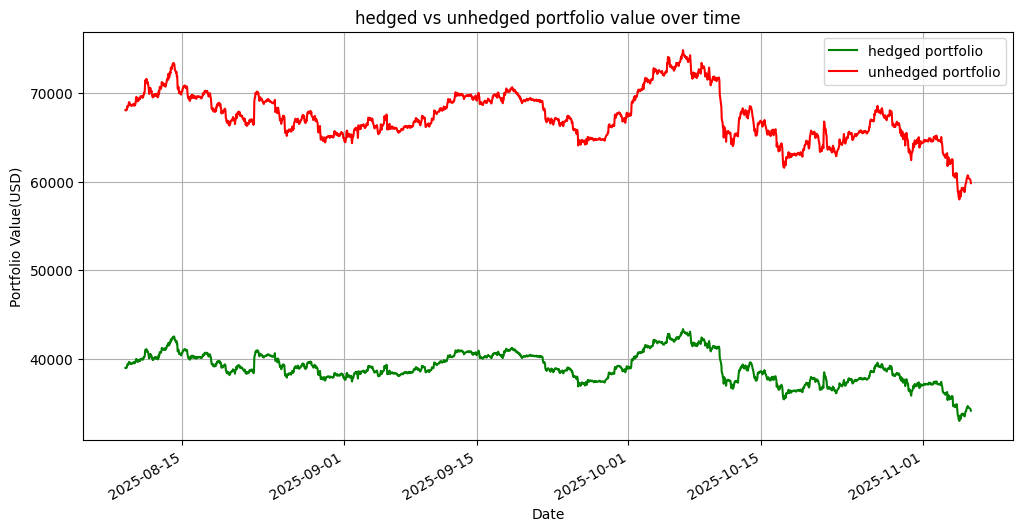

In [41]:
# Implement hedge logic which is: partial hedge (50% hedge of BTC exposure using Eth)

hedge_ratio = 0.5 # hedge 50% of BTC exposure
btc_position_value = portfolio['BTC-USD'] * data['Close', 'BTC-USD']
eth_price = data['Close', 'ETH-USD']

# Number of Eth unbits to short to hedge 50% of BTC exposure
eth_hedge_units = (btc_position_value * hedge_ratio) / eth_price

# New Eth position is now original + hedge
effective_eth_value = (portfolio['ETH-USD'] * data['Close', 'ETH-USD']) - (eth_hedge_units * data['Close', 'ETH-USD'])
#effective_eth_value.plot(title='effective Eth position over time')

# Updated portfolio value with hedge
hedged_portfolio_value = (
    (portfolio['BTC-USD'] * data['Close', 'BTC-USD']) +
    effective_eth_value +
    (portfolio['SOL-USD'] * data['Close', 'SOL-USD'])
)

plt.figure(figsize=(12, 6))
hedged_portfolio_value.plot(label = 'hedged portfolio', color = 'green')
portfolio_value.plot(label = 'unhedged portfolio', color='red')
plt.title('hedged vs unhedged portfolio value over time')

plt.xlabel('Date')
plt.ylabel('Portfolio Value(USD)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# PnL Attribution

unhedged_pnl = portfolio_value - portfolio_value.iloc[0]
hedged_pnl = hedged_portfolio_value - hedged_portfolio_value.iloc[0]

results = pd.DataFrame({
    'unhedged PnL': unhedged_pnl,
    'hedged PnL': hedged_pnl
})

results.tail()

,unhedged PnL,hedged PnL
Datetime,,
2025-11-05 20:00:00+00:00,-7653.315308,-4468.250854
2025-11-05 21:00:00+00:00,-7733.080994,-4508.764587
2025-11-06 00:00:00+00:00,-7830.892059,-4600.884247
2025-11-06 01:00:00+00:00,-7963.653351,-4670.336945
2025-11-06 02:00:00+00:00,-8267.556183,-4836.376495


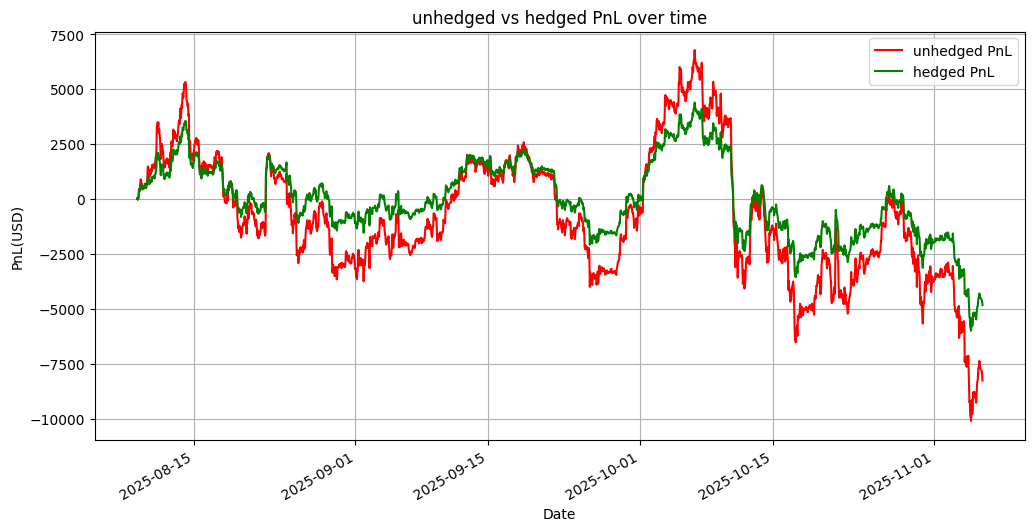

Deduction:
The partial hedge reduced the size of adverse swings while keeping the overall directional trend intact.
This stabilises PnL without fully neutralising exposure, improving risk efficiency during volatile periods.


In [43]:
# hedged vs unhedged PnL comparison plot

plt.figure(figsize=(12, 6))
unhedged_pnl.plot(label = 'unhedged PnL', color = 'red')
hedged_pnl.plot(label = 'hedged PnL', color = 'green')
plt.title('unhedged vs hedged PnL over time')
plt.xlabel('Date')
plt.ylabel('PnL(USD)')
plt.legend()
plt.grid(True)
plt.show()


# Deduction
print('Deduction:')
print('The partial hedge reduced the size of adverse swings while keeping the overall directional trend intact.' )
print( 'This stabilises PnL without fully neutralising exposure, improving risk efficiency during volatile periods.')

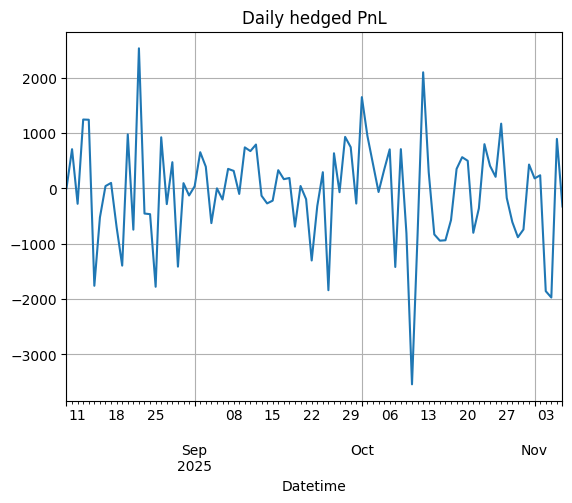

In [45]:
# Daily PnL summary
daily_pnl = hedged_pnl.resample('D').last().diff().fillna(0)
daily_pnl.plot(title='Daily hedged PnL')
plt.grid(True)
plt.show()